In [ ]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 549 kB 37.1 MB/s 
     |████████████████████████████████| 182 kB 78.1 MB/s 


In [ ]:
!pip uninstall fastai
!pip install -U fastai

Found existing installation: fastai 2.7.10
Uninstalling fastai-2.7.10:
  Would remove:
    /usr/local/bin/configure_accelerate
    /usr/local/lib/python3.8/dist-packages/fastai-2.7.10.dist-info/*
    /usr/local/lib/python3.8/dist-packages/fastai/*
Proceed (y/n)? ERROR: Operation cancelled by user
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import torchvision
import torchvision.transforms as T
import random
import numpy as np
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.pyplot as plt
#from cs231n.image_utils import SQUEEZENET_MEAN, SQUEEZENET_STD
from PIL import Image

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [ ]:
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os

from fastcore.all import *
# import timm
import time

In [ ]:
# serch image function using duckduckgo
import json

def search_images(term, max_images=200):
    url = 'https://duckduckgo.com/'
    res = urlread(url,data={'q':term})
    searchObj = re.search(r'vqd=([\d-]+)\&', res)
    requestUrl = url + 'i.js'
    params = dict(l='us-en', o='json', q=term, vqd=searchObj.group(1), f=',,,', p='1', v7exp='a')
    headers = dict( referer='https://duckduckgo.com/' )
    urls,data = set(),{'next':1}
    while len(urls)<max_images and 'next' in data:
        res = urlread(requestUrl, data=params, headers=headers)
        data = json.loads(res) if res else {}
        urls.update(L(data['results']).itemgot('image'))
        requestUrl = url + data['next']
        time.sleep(0.2)
    return L(urls)[:max_images]

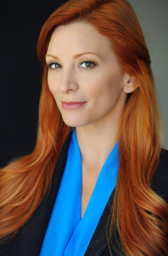

In [ ]:
# NOOTE: first try small amount
# see url
urls = search_images('female', max_images=1)
urls[0]
# see img
from fastdownload import download_url
dest = 'female.jpg' # 这个图片会在kaggle右侧栏data>output>/kaggle/working>当前notebook名字下面
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

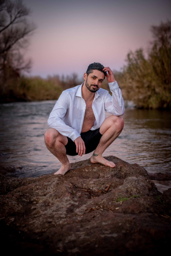

In [ ]:
# see another img
download_url(search_images('male', max_images=1)[0], 'male.jpg', show_progress=False)
Image.open('male.jpg').to_thumb(256,256)

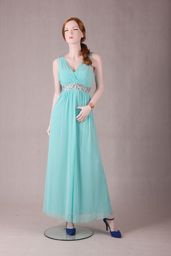

In [ ]:
download_url(search_images('female', max_images=2)[1], 'female.jpg', show_progress=False)
Image.open('female.jpg').to_thumb(256,256)

In [ ]:
# get all imgs
searches = 'female','male'
downloaded_path = Path('downloaded_female_or_not')
resized_path = Path("resized_female_or_not")
for o in searches:
    downloaded_dest = (downloaded_path/o)
    downloaded_dest.mkdir(exist_ok = True, parents = True)
    download_images(downloaded_dest, urls = search_images(f"{o} photo", max_images=400))
    resize_images(downloaded_path/o, max_size = 400, dest = resized_path/o)
path = resized_path

In [ ]:
# Some photos might not download correctly which could cause our model training to fail, so we'll remove them:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

In [ ]:
# Path.ls(Path("/content/resized_female_or_not/female photos"))
Path.ls(path/'female')
# path/resized_female_or_not)

(#388) [Path('resized_female_or_not/female/e181caae-3bea-462e-b191-014c0c39c643.jpg'),Path('resized_female_or_not/female/7e6def6e-889d-42b6-9c71-1524181abf08.jpg'),Path('resized_female_or_not/female/2d4e1bed-34e6-47cc-bcc4-57edd744035c.jpg'),Path('resized_female_or_not/female/c237652e-32fe-46f7-ab13-ce6ccb5cce40.jpg'),Path('resized_female_or_not/female/2f3d94e2-74dd-4a1e-b323-989bd161af7a.jpg'),Path('resized_female_or_not/female/a2fa2ec2-f3a5-4974-87f7-f22fb27863a6.jpg'),Path('resized_female_or_not/female/6a7fdf09-ec7e-4a2e-8e1d-35a79b2eafb4.jpg'),Path('resized_female_or_not/female/c945abf8-1289-4c6d-aec3-3a63105f7ce0.jpg'),Path('resized_female_or_not/female/d514b0f3-c428-4438-a74c-5e98711cee07.jpg'),Path('resized_female_or_not/female/42535aa5-0a4e-4832-83d3-7e1c18a2eb65.jpg')...]

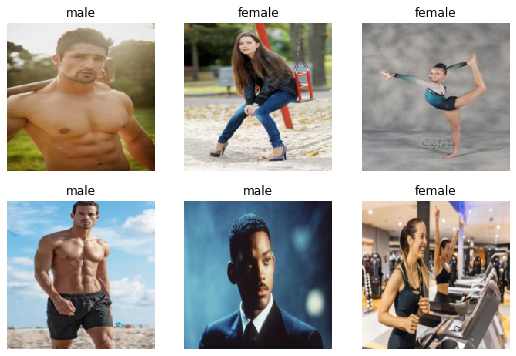

In [ ]:
# create `DataLoaders`
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files, # To find all the `inputs` to our model, run the `get_image_files` function (which returns a list of all image files in a path)
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label, # The labels (`y` values) is the name of the `parent` of each file
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)
# see if it's legit
dls.show_batch(max_n=6)

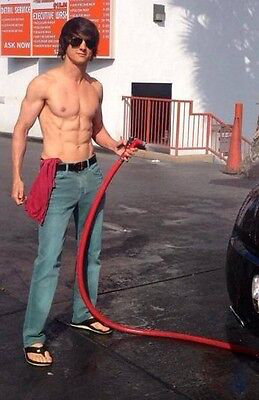

In [ ]:
dls.train_ds[0][0]

In [ ]:
dls.valid_ds[0]

(PILImage mode=RGB size=300x400, TensorCategory(1))

In [ ]:
with dls.valid.fake_l.no_multiproc():
    out = next(iter(dls.valid))

# out[0].size() # TensorImage torch.Size([64, 3, 192, 192]) 64个images
# out[1].size() # torch.Size([64]) 64个label（0/1）

TypeError: ignored

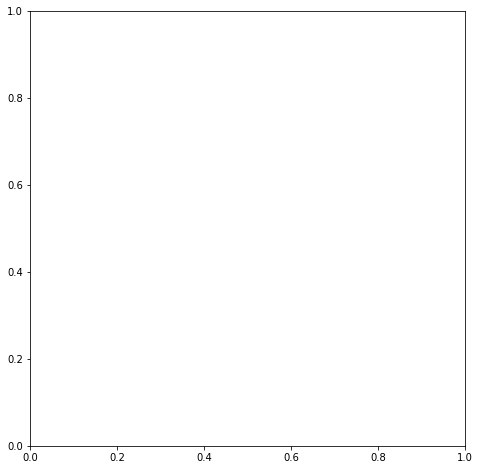

In [ ]:
plt.imshow(out[0][0])

In [ ]:
out[1][0]

TensorCategory(0, device='cuda:0')

## train model using transfer learning

In [ ]:
# train model using transfer learning
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3) # automatically uses best practices for fine tuning a pre-trained model, so we'll use that. In this case, the pretrained model was trained to recognise photos in `imagenet`

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
# train model using transfer learning
learn = vision_learner(dls, 'convnext_tiny_in22k', metrics=error_rate).to_fp16() # for models fastai doesn't provide, use string instead of just the name (resnet34)
# ???fp16?
# in22k: imageNet has 2 different dataset, one is thousands, another 22k, so _in22k is trained in 22k data
learn.fine_tune(3)

NameError: ignored

error_rate is 0.5x than resnet18, and size of model is 2.5x

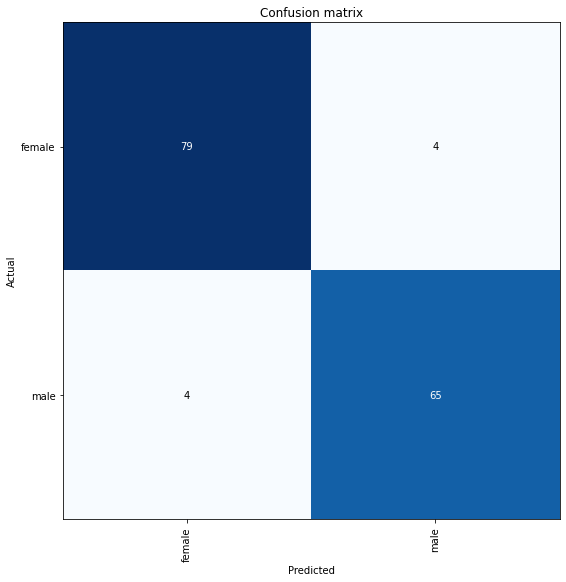

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

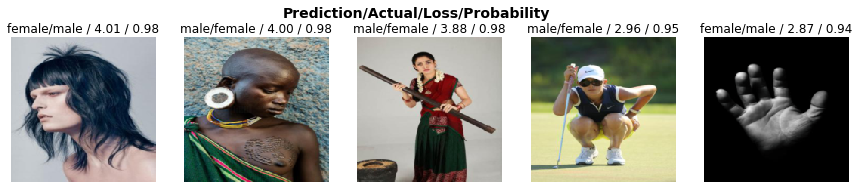

In [ ]:
interp.plot_top_losses(5, nrows=1)

In [ ]:
from fastai.vision.widgets import ImageClassifierCleaner
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [ ]:
# use the model
is_female,_,probs = learn.predict(PILImage.create('female.jpg')) # name of the category, category number, probability
print(f"This is a: {is_female}.")
print(f"Probability it's a female: {probs[0]:.4f}")

This is a: female.
Probability it's a female: 0.9997


In [ ]:
probs

TensorBase([9.9972e-01, 2.7734e-04])

In [ ]:
# predict in loop
labels = learn.dls.vocab
def predict(img):
   img = PILImage.create(img)
   pred,pred_idx,probs = learn.predict(img)
   return {labels[i]: float(probs[i]) for i in range(len(labels))}
   # or: for multi categories???
   # return dict(zip(labels, map(float, probs)))

## export model

In [ ]:
# export the model
learn.export('model.pkl')

## see model

model.pkl is an object called learner: 1.the list of pre-processing steps (as def in DataLoaders) 2. the trained model

In [ ]:
# see the model structure
m = learn.model
m

Sequential(
  (0): TimmBody(
    (model): ConvNeXt(
      (stem): Sequential(
        (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
        (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
      )
      (stages): Sequential(
        (0): ConvNeXtStage(
          (downsample): Identity()
          (blocks): Sequential(
            (0): ConvNeXtBlock(
              (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
              (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
              (mlp): Mlp(
                (fc1): Linear(in_features=96, out_features=384, bias=True)
                (act): GELU()
                (drop1): Dropout(p=0.0, inplace=False)
                (fc2): Linear(in_features=384, out_features=96, bias=True)
                (drop2): Dropout(p=0.0, inplace=False)
              )
              (drop_path): Identity()
            )
            (1): ConvNeXtBlock(
              (conv_dw): Conv2d(96, 

In [ ]:
# see the layers in the model
l = m.get_submodule('0.model.stem.1') # whi is TimmBody>ConvNeXt>Sequential>LayerNorm2d
# it is a math equation, and we can see the params
l

LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)

In [ ]:
list(l.parameters())

[Parameter containing:
 tensor([ 1.2543e+00,  1.9193e+00,  1.2196e+00,  1.0393e+00, -4.9810e-04,
          7.6562e-01,  8.8730e-01,  1.6316e+00,  7.0501e-01,  3.2890e+00,
          7.8586e-01, -1.1275e-03,  1.0005e+00, -1.5276e-03,  3.2970e+00,
         -6.4481e-04,  1.9839e+00,  1.0210e+00,  4.4526e+00,  2.5517e-01,
          2.7246e+00,  9.2699e-01,  1.2362e+00,  4.6018e-03,  1.7868e+00,
          5.4343e-01,  4.6258e+00,  1.1874e-02, -3.6868e-04,  3.4497e+00,
          1.3514e+00,  4.1255e+00,  2.6880e+00,  4.1204e+00,  3.4002e+00,
          8.4929e-01,  7.3605e-01,  3.9794e+00,  1.2861e+00,  6.4105e-01,
          2.6897e+00,  1.1174e+00,  1.1704e+00,  5.5309e-01,  2.3341e+00,
          1.1241e-03,  9.6932e-01,  1.2785e-03,  1.1975e+00,  1.7879e+00,
          4.0169e-01,  4.4996e-01,  9.7235e-01,  3.9888e+00,  6.5890e-01,
          6.8843e-01,  9.8562e-01,  2.7061e+00,  1.2166e+00,  7.6212e-01,
          3.3014e+00,  1.6198e+00,  9.5593e-01,  2.1204e+00,  6.3028e-01,
          4.033

#LIME

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import numpy as np
import os, json

import torch
from torchvision import models, transforms
from torch.autograd import Variable
import torch.nn.functional as F

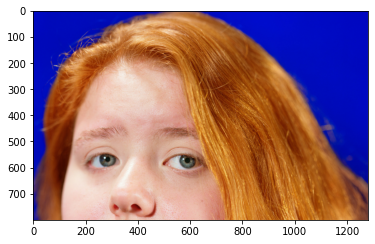

In [ ]:
# Load test image and see how it looks.
def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')

img = get_image('/content/female.jpg')
plt.imshow(img)

Convert this image to Pytorch tensor and also apply whitening as used by pretrained model.

In [ ]:
# resize and take the center part of image to what the model expects
def get_input_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ])

    return transf

def get_input_tensors(img):
    transf = get_input_transform()
    # unsqeeze converts single image to batch of 1
    return transf(img).unsqueeze(0).cuda()

In [ ]:
# Load the model for Resnet18 available in Pytorch.
#model = models.resnet18(pretrained=True)
model = learn.model

In [ ]:
# Load label texts for ImageNet predictions so we know what model is predicting
idx2label, cls2label, cls2idx = [], {}, {}
with open(os.path.abspath('/content/imagenet_class_index.json'), 'r') as read_file:
    class_idx = json.load(read_file)
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
    cls2label = {class_idx[str(k)][0]: class_idx[str(k)][1] for k in range(len(class_idx))}
    cls2idx = {class_idx[str(k)][0]: k for k in range(len(class_idx))}

In [ ]:
# Get the predicition for the image.
img_t = get_input_tensors(img)
model.eval()
logits = model(img_t)

In [ ]:
img_t.shape

torch.Size([1, 3, 224, 224])

In [ ]:
# Predicitions we got are logits. Let's pass that through softmax to get probabilities and class labels for top 5 predictions.
probs = F.softmax(logits, dim=1)
#probs5 = probs.topk(2)
prediction,_,probs = learn.predict(PILImage.create('female.jpg'))
#tuple((p,c, idx2label[c]) for p, c in zip(probs5[0][0].detach().cpu().numpy(), probs5[1][0].detach().cpu().numpy()))

In [ ]:
prediction

'male'

In [ ]:
probs

TensorBase([0.4597, 0.5403])

We are getting ready to use Lime. Lime produces the array of images from original input image by pertubation algorithm. So we need to provide two things:</br>
(1) original image as numpy array;</br>
(2) classification function that would take array of purturbed images as input and produce the probabilities for each class for each image as output.



In [ ]:
# For Pytorch, first we need to define two separate transforms: (1) to take PIL image, resize and crop it (2) take resized, cropped image and apply whitening.
def get_pil_transform():
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])

    return transf

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

Now we are ready to define classification function that Lime needs. The input to this function is numpy array of images where each image is ndarray of shape (channel, height, width). The output is numpy aaray of shape (image index, classes) where each value in array should be probability for that image, class combination.



In [ ]:
def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)

    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

In [ ]:
# Test the function for the sample image.
test_pred = batch_predict([pill_transf(img)])
test_pred.squeeze().argmax()

1

In [ ]:
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 275 kB 14.9 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=496285dd41fe5f3cdd08ebaaf285dd49e3cb780e69751a86bf1c496096110e2d
  Stored in directory: /root/.cache/pip/wheels/e6/a6/20/cc1e293fcdb67ede666fed293cb895395e7ecceb4467779546
Successfully built lime


In [ ]:
from lime import lime_image

In [ ]:
# create explanation for this prediciton
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pill_transf(img)),
                                         batch_predict, # classification function
                                         top_labels=5,
                                         hide_color=0,
                                         num_samples=1000) # number of images that will be sent to classification function

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
# Use mask on image and see the areas that are encouraging the top prediction.
from skimage.segmentation import mark_boundaries

label[0]

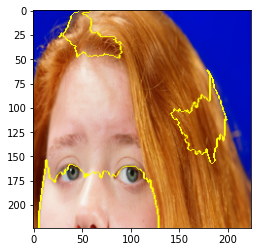

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

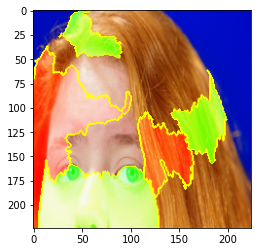

In [ ]:
# Turn on areas that contributes against the top prediction.
# Green means positive correlation, red means negative correlation.
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)

label[1]

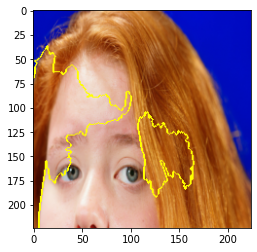

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[1], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

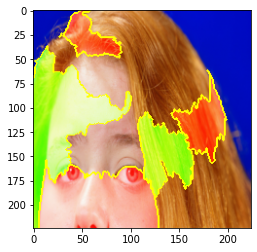

In [ ]:
# Turn on areas that contributes against the top prediction. Green for contribution; red for disapproval.
temp, mask = explanation.get_image_and_mask(explanation.top_labels[1], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)

#SHAP

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 575 kB 15.3 MB/s 


In [ ]:
import shap

In [ ]:
e = shap.DeepExplainer(model, img_t)
shap_values = e.shap_values(img_t)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [ ]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(img_t.cpu().numpy(), 1, -1), 1, 2)

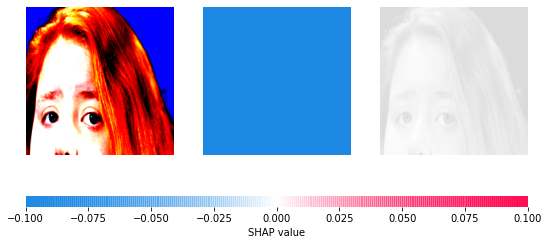

In [ ]:
# plot the feature attributions
# Red color means higher value of a feature. Blue means lower value of a feature.
shap.image_plot(shap_numpy, test_numpy)

In [ ]:
print("img_tensor: ", img_t.min(), img_t.max(), img_t.type())
print("shap_values: ", np.min(shap_values), np.max(shap_values), shap_values[0].dtype)
print("shap_numpy: ", np.min(shap_numpy), np.max(shap_numpy), shap_numpy[0].dtype)
print("test_numpy: ", np.min(test_numpy), np.max(test_numpy), test_numpy[0].dtype)

img_tensor:  tensor(-2.1179, device='cuda:0') tensor(2.4308, device='cuda:0') torch.cuda.FloatTensor
shap_values:  0.0 0.0 float64
shap_numpy:  0.0 0.0 float64
test_numpy:  -2.117904 2.4308496 float32


# Saliency Map

In [ ]:
from fastai.vision.learner import GradientCam

# Get the image to create the saliency map for
image = 'female.jpg'

# Create a GradientCam instance
gc = GradientCam(learn.model, learn.dls.device)

# Generate the saliency map for the image
saliency_map = gc.generate_cam(image)

ImportError: ignored

In [ ]:
# - X: Input images; Tensor of shape (N, 3, H, W)
# - y: Labels for X; LongTensor of shape (N,)
# - model: A pretrained CNN that will be used to compute the saliency map.

# - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the input images.
batchImages = out[0]
y = out[1]

# saliency = compute_saliency_maps(X, y, learn)

# Make sure the model is in "test" mode
learn.eval()

# Make input tensor require gradient
batchImages.requires_grad_()

saliency = None
##############################################################################
# forward and backward pass through #
# the model to compute the gradient of the correct class score with respect  #
# to each input image. You first want to compute the loss over the correct   #
# scores (we'll combine losses across a batch by summing), and then compute  #
# the gradients with a backward pass.                                        #
##############################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

#forward pass

# Get a tensor in the correct format for the model
# dls.valid_ds[0]
# dls.valid
# example_tensor = dls.valid_ds.one_item()[0]

# Create a tensor with the correct shape by concatenating
# the example tensor with the input tensor
# input_tensor = torch.cat([example_tensor, batchImages], dim=0)

# batchImages2 = batchImages.unsqueeze(dim=0)

example_tensor = dls.train_ds[0][0]

# Get the shape of the example tensor
batch_size, channels, height, width = example_tensor.shape

# Add a single dimension to the input tensor
# input_tensor = images.unsqueeze(dim=0)

# Reshape the tensor to have the same shape as the example tensor
input_tensor = input_tensor.view(batch_size, channels, height, width)

predictions = learn.predict(batchImages2)

# predict in loop
labels = learn.dls.vocab
def predict(img):
   img = PILImage.create(img)
   pred,pred_idx,probs = learn.predict(img)
   return probs # TensorBase([0.5839, 0.4161])
   #return {labels[i]: float(probs[i]) for i in range(len(labels))} # dict, {'female': 0.5838560461997986, 'male': 0.4161440134048462}
   # or: for multi categories???
   # return dict(zip(labels, map(float, probs)))

# Get a tensor in the correct format for the model
example_tensor = data.one_item()[0]

# Create a tensor with the correct shape by concatenating
# the example tensor with the input tensor
input_tensor = torch.cat([example_tensor, images], dim=0)
scores = predict("female.jpg")

def predictTensor(img):
   #img = PILImage.create(img)
   pred,pred_idx,probs = learn.predict(img)
   return {labels[i]: float(probs[i]) for i in range(len(labels))}
# scores = predictTensor(batchImages[0])
scores = learn.pred_batch(ds_type=DatasetType.Valid, batch=batchImages)
# scores = learn(batchImages[0])

# print(scores.shape) # torch.Size([5, 1000]) since 5 images, 1000 classes

#is_female,_,probs = learn.predict(PILImage.create('female.jpg'))
scores = scores.to("cuda:0")
scores = (scores.gather(1, y.view(-1, 1)).squeeze())
# print(scores.shape) # torch.Size([5])

# print(scores) #tensor([24.1313, 25.1475, 38.8825, 25.4514, 30.2723], grad_fn=)

#backward pass
scores.backward(torch.FloatTensor([1.0]*scores.shape[0]))

#saliency
saliency, _ = torch.max(X.grad.data.abs(), dim=1)

# torch.max(input, dim, keepdim=False, out=None) -> (Tensor, LongTensor)

# Returns a namedtuple (values, indices) where values is the maximum value of each row of the input tensor
# in the given dimension dim. And indices is the index location of each maximum value found (argmax).
# If keepdim is True, the output tensors are of the same size as input except in the dimension dim
# where they are of size 1. Otherwise, dim is squeezed (see torch.squeeze()),
# resulting in the output tensors having 1 fewer dimension than input.


# Convert the saliency map from Torch Tensor to numpy array and show images
# and saliency maps together.
saliency = saliency.numpy()
N = X.shape[0]
for i in range(N):
    plt.subplot(2, N, i + 1)
    plt.imshow(X[i])
    plt.axis('off')
    plt.title(class_names[y[i]])
    plt.subplot(2, N, N + i + 1)
    plt.imshow(saliency[i], cmap=plt.cm.hot)
    plt.axis('off')
    plt.gcf().set_size_inches(12, 5)
plt.show()

ValueError: ignored

In [ ]:
example_tensor = data.train_ds[0][0]


NameError: ignored

In [ ]:
def compute_saliency_maps(X, y, model):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input images; Tensor of shape (N, 3, H, W)
    - y: Labels for X; LongTensor of shape (N,)
    - model: A pretrained CNN that will be used to compute the saliency map.

    Returns:
    - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the input
    images.
    """
    # Make sure the model is in "test" mode
    model.eval()

    # Make input tensor require gradient
    X.requires_grad_()

    saliency = None
    ##############################################################################
    # TODO: Implement this function. Perform a forward and backward pass through #
    # the model to compute the gradient of the correct class score with respect  #
    # to each input image. You first want to compute the loss over the correct   #
    # scores (we'll combine losses across a batch by summing), and then compute  #
    # the gradients with a backward pass.                                        #
    ##############################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    #forward pass
    scores = model(X)
    # print(scores.shape) # torch.Size([5, 1000]) since 5 images, 1000 classes
    scores = (scores.gather(1, y.view(-1, 1)).squeeze())
    # print(scores.shape) # torch.Size([5])

    # print(scores) #tensor([24.1313, 25.1475, 38.8825, 25.4514, 30.2723], grad_fn=)

    #backward pass
    scores.backward(torch.FloatTensor([1.0]*scores.shape[0]))

    #saliency
    saliency, _ = torch.max(X.grad.data.abs(), dim=1)

    # torch.max(input, dim, keepdim=False, out=None) -> (Tensor, LongTensor)

    # Returns a namedtuple (values, indices) where values is the maximum value of each row of the input tensor
    # in the given dimension dim. And indices is the index location of each maximum value found (argmax).
    # If keepdim is True, the output tensors are of the same size as input except in the dimension dim
    # where they are of size 1. Otherwise, dim is squeezed (see torch.squeeze()),
    # resulting in the output tensors having 1 fewer dimension than input.


    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    return saliency

In [ ]:
def show_saliency_maps(X, y):
    # Convert X and y from numpy arrays to Torch Tensors
    # X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
    # y_tensor = torch.LongTensor(y)

    # Compute saliency maps for images in X
    # saliency = compute_saliency_maps(X_tensor, y_tensor, model)
    saliency = compute_saliency_maps(X, y, learn)

    # Convert the saliency map from Torch Tensor to numpy array and show images
    # and saliency maps together.
    saliency = saliency.numpy()
    N = X.shape[0]
    for i in range(N):
        plt.subplot(2, N, i + 1)
        plt.imshow(X[i])
        plt.axis('off')
        plt.title(class_names[y[i]])
        plt.subplot(2, N, N + i + 1)
        plt.imshow(saliency[i], cmap=plt.cm.hot)
        plt.axis('off')
        plt.gcf().set_size_inches(12, 5)
    plt.show()

show_saliency_maps(X, y)

'torch.cuda.FloatTensor'

# other

In [ ]:
def make_fooling_image(X, target_y, model):
    """
    Generate a fooling image that is close to X, but that the model classifies
    as target_y.

    Inputs:
    - X: Input image; Tensor of shape (1, 3, 224, 224)
    - target_y: An integer in the range [0, 1000)
    - model: A pretrained CNN

    Returns:
    - X_fooling: An image that is close to X, but that is classifed as target_y
    by the model.
    """
    # Initialize our fooling image to the input image, and make it require gradient
    X_fooling = X.clone()
    X_fooling = X_fooling.requires_grad_()

    learning_rate = 1
    ##############################################################################
    # TODO: Generate a fooling image X_fooling that the model will classify as   #
    # the class target_y. You should perform gradient ascent on the score of the #
    # target class, stopping when the model is fooled.                           #
    # When computing an update step, first normalize the gradient:               #
    #   dX = learning_rate * g / ||g||_2                                         #
    #                                                                            #
    # You should write a training loop.                                          #
    #                                                                            #
    # HINT: For most examples, you should be able to generate a fooling image    #
    # in fewer than 100 iterations of gradient ascent.                           #
    # You can print your progress over iterations to check your algorithm.       #
    ##############################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    while True:
        scores = model.predict(X_fooling)
        _, idx = torch.max(scores, 1)
        if (idx != target_y):
            scores[:,target_y].backward()

            # https://pytorch.org/tutorials/beginner/examples_autograd/two_layer_net_autograd.html
            # Manually update weights using gradient descent. Wrap in torch.no_grad()
            # because weights have requires_grad=True, but we don't need to track this
            # in autograd.
            with torch.no_grad():
                dX = learning_rate*X_fooling.grad/torch.norm(X_fooling.grad)
                X_fooling += dX
                X_fooling.grad.zero_()
        else:
            break


    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    return X_fooling



In [ ]:
X = X_tensor.to("cpu")
X_fooling = X.clone()
X_fooling = X_fooling.requires_grad_()

learning_rate = 1
##############################################################################
# TODO: Generate a fooling image X_fooling that the model will classify as   #
# the class target_y. You should perform gradient ascent on the score of the #
# target class, stopping when the model is fooled.                           #
# When computing an update step, first normalize the gradient:               #
#   dX = learning_rate * g / ||g||_2                                         #
#                                                                            #
# You should write a training loop.                                          #
#                                                                            #
# HINT: For most examples, you should be able to generate a fooling image    #
# in fewer than 100 iterations of gradient ascent.                           #
# You can print your progress over iterations to check your algorithm.       #
##############################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

while True:
    is_female,idx,scores = learn.predict(X_fooling)
    print(idx)
    print(scores[target_y])
    print(type(is_female))
    # _, idx = torch.max(scores)
    if (idx != target_y):
        scores[target_y].backward()

        # https://pytorch.org/tutorials/beginner/examples_autograd/two_layer_net_autograd.html
        # Manually update weights using gradient descent. Wrap in torch.no_grad()
        # because weights have requires_grad=True, but we don't need to track this
        # in autograd.
        with torch.no_grad():
            dX = learning_rate*X_fooling.grad/torch.norm(X_fooling.grad)
            X_fooling += dX
            X_fooling.grad.zero_()
    else:
        break

NameError: ignored

In [ ]:
target_y

TensorCategory(0, device='cuda:0')

In [ ]:
idx = 0
target_y = out[1][0]

#X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
X_tensor = out[0][0]
X_fooling = make_fooling_image(X_tensor, target_y, learn)

print(X_tensor.shape)
print(X_tensor[0].shape)
print(X_tensor[0:1].shape)

scores = model(X_fooling)
assert target_y == scores.data.max(1)[1][0].item(), 'The model is not fooled!'

TypeError: ignored

In [ ]:
X_fooling_np = deprocess(X_fooling.clone())
X_fooling_np = np.asarray(X_fooling_np).astype(np.uint8)

plt.subplot(1, 4, 1)
plt.imshow(X[idx])
plt.title(class_names[y[idx]])
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(X_fooling_np)
plt.title(class_names[target_y])
plt.axis('off')

plt.subplot(1, 4, 3)
X_pre = preprocess(Image.fromarray(X[idx]))
diff = np.asarray(deprocess(X_fooling - X_pre, should_rescale=False))
plt.imshow(diff)
plt.title('Difference')
plt.axis('off')

plt.subplot(1, 4, 4)
diff = np.asarray(deprocess(10 * (X_fooling - X_pre), should_rescale=False))
plt.imshow(diff)
plt.title('Magnified difference (10x)')
plt.axis('off')

plt.gcf().set_size_inches(12, 5)
plt.show()